# Yeast data analysis

In [24]:
from Bio import AlignIO, Seq
from Bio.Align import MultipleSeqAlignment
# from Bio.Alphabet import IUPAC, Gapped
import numpy as np
import pandas as pd
from matplotlib import rc
import glob, tqdm, os, collections
from ete3 import Tree,NCBITaxa
# import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
%matplotlib inline
# import networkx as nx


# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'
# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
species_remove_manually = []
#align_file = '/Users/daviddylus/projects/r2t/yeast/yeast_phylogeny/r2t_380/concat_merge_370/concat_merge_370.phy'
cov_file = '/Volumes/Recovery 1/projects/r2t/yeast/yeast_phylogeny/r2t_435/all_cov2.txt'
sc_file = '/Volumes/Recovery 1/projects/r2t/yeast/yeast_phylogeny/r2t_435/all_sc2.txt'
# full alignment
#align_file = '/Users/daviddylus/projects/r2t/yeast/yeast_phylogeny/r2t_385/full/concat_merge_aa.phy'

# shen et al alignment
align_dna = '/Volumes/Recovery 1/projects/r2t/yeast/yeast_phylogeny/r2t_435/concat_merge_dna.phy'
align_file = '/Users/daviddylus/projects/r2t/yeast/yeast_phylogeny/r2t_435/like_shen_2018/concat.fa'
# sra_file = '/Users/daviddylus/Desktop/test6.csv'

rokas_alignment = '/Users/daviddylus/Projects/r2t/yeast/1_molecular_phylogenetics/0_data_matrices/0_data_matrices/343_2408OGs/343_2408OGs.fasta'



ncbi_tree_file = '/Volumes/Recovery 1/projects/r2t/yeast/yeast_phylogeny/r2t_435/like_shen_2018/id_ncbi.nwk'
tree_file = '/Volumes/Recovery 1/projects/r2t/yeast/yeast_phylogeny/r2t_435/like_shen_2018/concat.fa.contree'
rokas_tree = '/Users/daviddylus/Downloads/1_molecular_phylogenetics/1_27phylogenetic_trees/343_2408OGs.treefile'
TREE_DIR = '/Users/daviddylus/projects/r2t/yeast/yeast_phylogeny/r2t_435/like_shen_2018/'


In [4]:
rokas_alignment = '/Users/daviddylus/Projects/r2t/yeast/1_molecular_phylogenetics/0_data_matrices/0_data_matrices/343_2408OGs/343_2408OGs.fasta'
alignment = AlignIO.read(rokas_alignment, 'fasta')
alignment


<<class 'Bio.Align.MultipleSeqAlignment'> instance (343 records of length 1162805, SingleLetterAlphabet()) at 7fb357870898>

In [6]:
r2t_alignment = '/Volumes/Recovery 1/projects/r2t/yeast/yeast_phylogeny/r2t_435/like_shen_2018/concat.fa'
alignment = AlignIO.read(r2t_alignment, 'fasta')
alignment

<<class 'Bio.Align.MultipleSeqAlignment'> instance (435 records of length 333891, SingleLetterAlphabet()) at 7fb35787f0f0>

In [7]:
def repel_labels(ax, x, y, labels, k=0.01):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift
    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='red'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])


def get_alignment(alignment, species_list):
    keep_species = []
    for i, record in enumerate(alignment):
        if record.id not in species_list:
            keep_species.append(record)
    return MultipleSeqAlignment(keep_species, Gapped(IUPAC.protein, "-"))

def write_alignment(output, alignment):
    AlignIO.write(alignment, output, 'phylip-relaxed')
    
def get_name_to_id(df):
    name_to_id = {}
    index = 0
    for ogr in sorted(set(df.Organism)):
        #     print(ogr)
        if len(ogr.split(" ")) > 2:
            new_id = ogr.split(" ")[0][0:3].upper() \
            + ogr.split(" ")[2][0:2].upper()
        elif len(ogr.split(" ")) > 1:
            new_id = ogr.split(" ")[0][0:3].upper() \
            + ogr.split(" ")[1][0:2].upper()
        else:
            new_id = ogr.split(" ")[0][0:3].upper()+'sp'

        if new_id in name_to_id.values():
            use_id = new_id[0:4]+str(index)
            index = index + 1
        else:
            index = 0
            use_id = new_id
        name_to_id[ogr] = use_id
    out_dict = {'names':list(name_to_id.keys()), 'ids':list(name_to_id.values())}

    df = pd.DataFrame(data=out_dict)
#     df.to_csv('sra_species_to_id.csv')
    return name_to_id

## Read in all coverages and sequence reconstructions

In [10]:
cov_df = pd.read_csv(cov_file)
sc_df = pd.read_csv(sc_file)
sc_df.head()

#species        og     gene_id  map_seq_completeness  ref_seq_completeness  \
0    SPAPN  OG187848  SPAPN03764              0.893720              0.893720   
1    DEBHA  OG187943  DEBHA01542              0.441767              0.441767   
2    PICST  OG188155  PICST04426              0.649180              0.649180   
3    CANTE  OG188277  CANTE03209              0.274401              0.274401   
4    CANAW  OG188297  CANAW02317              0.577550              0.577550   

   inferred_len  given_len  ref_len                file  
0           185        207      207  ACIAC_1_all_sc.txt  
1           440        996      996  ACIAC_1_all_sc.txt  
2           594        915      915  ACIAC_1_all_sc.txt  
3           596       2172     2172  ACIAC_1_all_sc.txt  
4          1523       2637     2637  ACIAC_1_all_sc.txt

## Get all distances between pairs and the closest ref by max ref species used from OGs

In [13]:
ncbi_tree = Tree(ncbi_tree_file)
sp_dist = {sp:{} for sp in ncbi_tree.get_leaf_names()}
for sp1 in tqdm.tqdm_notebook(ncbi_tree.get_leaf_names()):
#     if len(sp1.split()) > 2:
#         print(sp1)
    for sp2 in ncbi_tree.get_leaf_names():
#         print('nan' in sp2)
        if not ('nan' in sp1 or 'nan' in sp2):
            if sp1 != sp2:
                sp_dist[sp1][sp2] = ncbi_tree.get_distance(sp1,sp2)
            else:
                sp_dist[sp1][sp2] = 0
sp_dist_df = pd.DataFrame(sp_dist)
sp_dist_df.describe()

/Users/daviddylus/miniconda3/envs/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/390 [00:00<?, ?it/s]

ACIAC_1     ALLHY_1     AMBAM_1     AMBKA_1     AMBMA_1     AMBMO_1  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  360.000000   
mean     4.886111    4.113889    5.908333    5.908333    5.908333    5.908333   
std      0.970786    0.758114    1.112070    1.112070    1.112070    1.112070   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      5.000000    4.000000    6.000000    6.000000    6.000000    6.000000   
50%      5.000000    4.000000    6.000000    6.000000    6.000000    6.000000   
75%      5.000000    4.000000    6.000000    6.000000    6.000000    6.000000   
max      9.000000    8.000000   10.000000   10.000000   10.000000   10.000000   

          AMBOR_1     AMBPH_1     AMBPS_1     AMBVA_1  ...     ZYGCB_1  \
count  360.000000  360.000000  360.000000  360.000000  ...  360.000000   
mean     5.908333    5.908333    5.908333    5.908333  ...    5.708333   
std      1.112070    1.112070    1.112070    1.112070  ...    1.199321   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      6.000000    6.000000    6.000000    6.000000  ...    5.000000   
50%      6.000000    6.000000    6.000000    6.000000  ...    6.000000   
75%      6.000000    6.000000    6.000000    6.000000  ...    6.000000   
max     10.000000   10.000000   10.000000   10.000000  ...   10.000000   

          ZYGFL_1     ZYGHE_1     ZYGKO_1     ZYGME_1     ZYGMR_1     ZYGOF_1  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  360.000000   
mean     5.725000    5.963889    5.708333    5.963889    5.725000    5.963889   
std      1.160846    1.004905    1.199321    1.004905    1.160846    1.004905   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      5.000000    6.000000    5.000000    6.000000    5.000000    6.000000   
50%      6.000000    6.000000    6.000000    6.000000    6.000000    6.000000   
75%      6.000000    6.000000    6.000000    6.000000    6.000000    6.000000   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

          ZYGSA_1       ZYMTR  nan  
count  360.000000  360.000000  0.0  
mean     5.708333    8.825000  NaN  
std      1.199321    1.001357  NaN  
min      0.000000    0.000000  NaN  
25%      5.000000    9.000000  NaN  
50%      6.000000    9.000000  NaN  
75%      6.000000    9.000000  NaN  
max     10.000000   10.000000  NaN  

[8 rows x 361 columns]

## Transform all coverages and sequence reconstructions into dictionary to calculate the grand mean

In [14]:
cov_dic = {}
for mapped_species in tqdm.tqdm_notebook(set(cov_df['file'])):
    species_cov = cov_df.loc[cov_df['file'] == mapped_species]
    cov_dic[mapped_species.replace('_all_cov.txt','')] = {r['og']:[r['coverage'],r['std']] for i,r in species_cov.iterrows()}
# cov_dic

/Users/daviddylus/miniconda3/envs/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/405 [00:00<?, ?it/s]

In [15]:
sc_dic = {}
for mapped_species in tqdm.tqdm_notebook(set(sc_df['file'])):
    species_sc = sc_df.loc[sc_df['file'] == mapped_species]
    sc_dic[mapped_species.replace('_all_sc.txt','')] = {r['og']:[r['inferred_len'],r['ref_len']] for i,r in species_sc.iterrows()}
# sc_dic

/Users/daviddylus/miniconda3/envs/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/405 [00:00<?, ?it/s]

In [16]:
out_cov = {'mean_coverage':[], 'species':[], 'median_coverage':[], 'num_ogs':[]}

for k1,v1 in tqdm.tqdm_notebook(cov_dic.items()):
    scalled_coverages = [x[0]*sc_dic[k1][a][0] for a,x in v1.items()]
    num_values = [sc_dic[k1][a][0] for a,x in v1.items()]
    out_cov['mean_coverage'].append(np.sum(scalled_coverages)/np.sum(num_values))
    out_cov['median_coverage'].append(np.median(scalled_coverages))
    out_cov['num_ogs'].append(len(scalled_coverages))
    out_cov['species'].append(k1)

/Users/daviddylus/miniconda3/envs/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/405 [00:00<?, ?it/s]

In [17]:
cov_df_new = pd.DataFrame(out_cov) 
cov_df_new.head()

mean_coverage  median_coverage  num_ogs  species
0      27.575029     26533.827308     2754  KLUDO_1
1      49.077584     15646.000000     1315  METCE_1
2      38.359317     38844.295267     2424  YARBU_1
3     189.868662     64841.515116     2167  SACBA_1
4      26.292437     11003.909735     1487  CYBXY_1

In [18]:
max_used_sp = {}
for sp in tqdm.tqdm_notebook(list(set(cov_df.file))):
    sub_df = cov_df.loc[cov_df.file == sp]
    counts = collections.Counter(sub_df['#species'])
    top = counts.most_common(1)[0]
    max_used_sp[sp.replace('_all_cov.txt','')] = top[0]

/Users/daviddylus/miniconda3/envs/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/405 [00:00<?, ?it/s]

In [19]:
count_max_used_sp = {v:0 for v in set(max_used_sp.values())}
for v in max_used_sp.values():
    count_max_used_sp[v] += 1
count_max_used_sp
# max_used_sp

{'ASHGO': 3,
 'ASPGL': 2,
 'ASPOR': 2,
 'CANAL': 31,
 'CANAW': 2,
 'CANGA': 4,
 'CANTE': 6,
 'COCLU': 1,
 'DEBHA': 23,
 'DEKBR': 32,
 'KAZNA': 1,
 'KLULA': 13,
 'KOMPG': 10,
 'LACTC': 5,
 'LODEL': 2,
 'NEUCR': 1,
 'PICGU': 4,
 'PICST': 87,
 'SCLS1': 2,
 'SPAPN': 22,
 'THIHE': 1,
 'VANPO': 46,
 'YARLI': 56,
 'YEASA': 2,
 'YEASO': 1,
 'YEAST': 33,
 'ZYGRO': 12,
 'ZYMTR': 1}

In [16]:
# shen_alignment_ids = [r.id for r in shen_alignment]
# for r in alignment:
#     if r.id not in shen_alignment_ids:
#         print(r.id)

## Get alignment and compute the number of positions that are not ? or -

In [20]:
print(alignment[0])

ID: CANAU_1
Name: CANAU_1
Description: CANAU_1 <unknown description>
Number of features: 0
Seq('----EEWEIKKYWEIFQGLKPRDNKLNR-TVSPVLKNSRLKDDQLSKIW-LSDI...---', SingleLetterAlphabet())


In [21]:
# Get ratio of aa to ?,-,X
ratio = {'species':[], 'ratio':[], 'aas':[], 'scaled_ratio': []}
species_to_remove_ratio = []
X = 0.16
ratio_b_X = []
for r in alignment:
    xxs = str(r.seq).count("X")
#     print(xxs)
    qmarks = str(r.seq).count("?")
#     print(qmarks)
    dashes = str(r.seq).count("-")
#     print(dashes)
    seq_len = len(r.seq) - xxs - qmarks - dashes
#     print(seq_len)
    full = len(r.seq) - dashes - qmarks
#     print(full)
#     x = 1-((xxs + qmarks + dashes) / full)
    x =  seq_len / len(r.seq)
#     x = seq_len / full
#     print(x)
    ratio['species'].append(r.id)
    ratio['ratio'].append(x)
    ratio['aas'].append(seq_len)
    ratio['scaled_ratio'].append(seq_len/1528389)
    if x >= X:
        ratio_b_X.append(x)
    else:
        species_to_remove_ratio.append(r.id)
#     if x > 1:
#         break
    
ratios = np.array(list(ratio.values()))
print('{} species removed. Dataset with {} species'.format(len(species_to_remove_ratio), len(alignment)-len(species_to_remove_ratio)))
print(len(ratio_b_X))
df_len = pd.DataFrame(ratio)
df_len.sort_values(by='ratio', ascending=False).head()

17 species removed. Dataset with 418 species
418


aas     ratio  scaled_ratio  species
426  306346  0.917503      0.200437  CANGR_1
178  305708  0.915592      0.200020  DEBFA_1
264  305683  0.915517      0.200003  ZYGSA_1
392  305157  0.913942      0.199659  DEBHA_1
363  305116  0.913819      0.199632  SACWE_1

In [32]:
df_len.to_csv('~/Projects/r2t/yeast/aa_in_alignment.csv', index=False)

In [29]:
dna_alignment = AlignIO.read(align_dna, 'phylip-relaxed')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 1155: invalid start byte

HBox(children=(IntProgress(value=0, max=436), HTML(value='')))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd505cc9278>]], dtype=object)

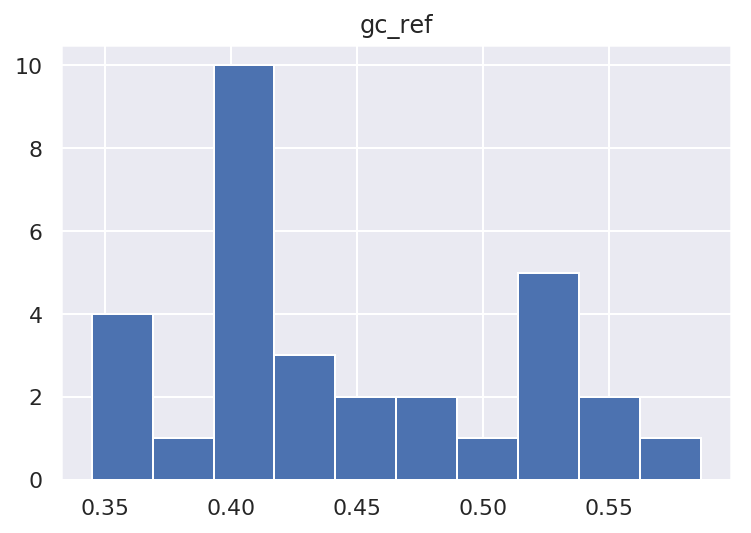

In [19]:
# Load alignment
gc = {}
for r in tqdm.tqdm_notebook(dna_alignment):
    g = str(r.seq).upper().count('G')
    c = str(r.seq).upper().count('C')
    t = str(r.seq).upper().count('T')
    a = str(r.seq).upper().count('A')
    n = str(r.seq).upper().count('N')
    dash = str(r.seq).upper().count('-')
    question = str(r.seq).upper().count('?')
    gc[r.id.split()[0]] = (g+c) / (g+c+a+t)
# print([v for k,v in gc.items() if '_1' not in gc.keys()])
gc_df = pd.DataFrame({'gc_ref':[v for k,v in gc.items() if not '_1' in k]})
gc_df.hist()

In [20]:
gc_df

gc_ref
0   0.539700
1   0.428592
2   0.449403
3   0.520183
4   0.406956
5   0.506141
6   0.526124
7   0.429578
8   0.404569
9   0.402177
10  0.400880
11  0.344862
12  0.378347
13  0.417192
14  0.518308
15  0.395015
16  0.523431
17  0.368452
18  0.403205
19  0.398604
20  0.352258
21  0.586384
22  0.541861
23  0.469850
24  0.471331
25  0.345309
26  0.450394
27  0.534501
28  0.402646
29  0.402201
30  0.433622

## Get all branch lengths that lead to leaves

In [26]:
from ete3 import Tree,NCBITaxa
t = Tree(tree_file)
branch_lengths = {}
for n in t.traverse('postorder'):
    if n.is_leaf:
#         print(n.name)
        branch_lengths[n.name] = n.dist
# with sns.axes_style('white'):
#     sns.distplot(branch_lengths)

## Read in SRA info file and integrate it to r2t generated output

In [27]:
df = pd.read_csv(sra_file)
df.head()

df2 = df.dropna(subset=['r2tid',])
df2

NameError: name 'sra_file' is not defined

In [24]:
df.columns

Index(['r2t', 'rokas', 'species', 'use', 'new', 'taxid', 'r2tid', 'rokasid',
       'genus', 'rokas_classification', 'order', 'family', 'r2t_qmarks',
       'r2t_seq_len', 'r2t_dashes', 'r2t_xxs', 'rokas_qmarks', 'rokas_seq_len',
       'rokas_dashes', 'rokas_xxs', 'ref', 'Run', 'Instrument',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'ReleaseDate',
       'MBytes', 'MBases', 'Platform', 'ReleaseYear', 'AvgSpotLen'],
      dtype='object')

In [25]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df[df.Organism == 'Blastobotrys attinorum'])
    
print('Coverage min {} and max {}'.format(min(df2.MBases)/2800,max(df2.MBases)/2800))
df[["ReleaseDate"]] = df[["ReleaseDate"]].apply(pd.to_datetime)
print(min(df.ReleaseDate))

Coverage min 0.06607142857142857 and max 17.624642857142856
2010-06-30 00:00:00


In [26]:
num_ogs_ref={'ASHGO':2634,
'ASPGL':2122,
'ASPOR':2087,
'CANAL':2866,
'CANAW':2672,
'CANGA':2441,
'CANTE':2681,
'COCLU':2086,
'DEBHA':2832,
'DEKBR':2298,
'KAZNA':2597,
'KLULA':2669,
'KOMPG':2640,
'LACTC':2755,
'LODEL':2362,
'NEUCR':1613,
'PASFU':2056,
'PICGU':2555,
'PICST':2786,
'SCHPO':1937,
'SCLS1':1979,
'SPAPN':2670,
'THIHE':2047,
'VANPO':2524,
'YARLI':2335,
'YEASA':1616,
'YEASO':1468,
'YEAST':2792,
'YEASV':1750,
'ZYGRO':2688,
'ZYMTR':2110}

In [27]:
df2['gc'] = 0.0
df2['ref_dist'] = 0.0
df2['ratio'] = 0.0
df2['scaled_ratio'] = 0
df2['aa_len'] = 0
df2['num_ogs'] = 0
df2['out_mean_cov'] = 0.0
df2['branch_length'] = 0.0
df2['max_used_sp'] = None

for i,r in df2.iterrows():
    old_id = r.r2tid
    if r.ref is np.NAN and r.Run is not np.NAN and r.r2t_seq_len > 0:
        if '_1' in old_id and 'KLULA_1' not in old_id and 'METHA_1' not in old_id:
            if old_id in sp_dist.keys() and old_id in max_used_sp.keys():
                if max_used_sp[old_id] in sp_dist.keys():
                    df2.at[i,'ref_dist'] = sp_dist[old_id][max_used_sp[old_id]]
                else:
                    df2.at[i,'ref_dist'] = 0      
            else:
                df2.at[i,'ref_dist'] = 0
            df2.at[i,'gc'] = gc[old_id]
            df2.at[i,'coverage'] = r['MBases']/2800
            df2.at[i,'ratio'] = df_len.loc[df_len['species'] == old_id]['ratio'].iloc[0]
            df2.at[i,'scaled_ratio'] = df_len.loc[df_len['species'] == old_id]['scaled_ratio'].iloc[0]
            df2.at[i,'aa_len'] = df_len.loc[df_len['species'] == old_id]['aas'].iloc[0]
            df2.at[i,'num_ogs'] = cov_df_new.loc[cov_df_new['species'] == old_id]['num_ogs'].iloc[0]
            df2.at[i,'out_mean_cov'] = cov_df_new.loc[cov_df_new['species'] == old_id]['mean_coverage'].iloc[0]
            df2.at[i,'branch_length'] = branch_lengths[old_id]
            df2.at[i,'max_used_sp'] = max_used_sp[old_id]
    elif r.ref is not np.NAN and r.r2t_seq_len > 0:
#         print(old_id)
        df2.at[i,'ref_dist'] = 0.0
        df2.at[i,'gc'] = gc[old_id]
        df2.at[i,'coverage'] = 100.0
        df2.at[i,'ratio'] = df_len.loc[df_len['species'] == old_id]['ratio'].iloc[0]
        df2.at[i,'scaled_ratio'] = df_len.loc[df_len['species'] == old_id]['scaled_ratio'].iloc[0]
        df2.at[i,'aa_len'] = df_len.loc[df_len['species'] == old_id]['aas'].iloc[0]
        df2.at[i,'num_ogs'] = num_ogs_ref[old_id]
        df2.at[i,'out_mean_cov'] = 0.0
        df2.at[i,'branch_length'] = branch_lengths[old_id]
        df2.at[i,'max_used_sp'] = old_id
df2.head()

/Users/daviddylus/miniconda3/envs/r2t/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/daviddylus/miniconda3/envs/r2t/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/daviddylus/miniconda3/envs/r2t/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

r2t  \
0  Aciculoconidium aculeatum NRRL YB-4298   
1         Alloascoidea hylecoeti JCM 7604   
2      Ambrosiozyma ambrosiae NRRL Y-7524   
3    Ambrosiozyma kashinagacola JCM 15019   
4       Ambrosiozyma maleeae NRRL Y-63635   

                                    rokas                     species  \
0  Aciculoconidium aculeatum NRRL YB-4298   Aciculoconidium aculeatum   
1         Alloascoidea hylecoeti JCM 7604      Alloascoidea hylecoeti   
2      Ambrosiozyma ambrosiae NRRL Y-7524      Ambrosiozyma ambrosiae   
3    Ambrosiozyma kashinagacola JCM 15019  Ambrosiozyma kashinagacola   
4       Ambrosiozyma maleeae NRRL Y-63635        Ambrosiozyma maleeae   

                                      use                         new   taxid  \
0  Aciculoconidium aculeatum NRRL YB-4298   Aciculoconidium aculeatum   43968   
1         Alloascoidea hylecoeti JCM 7604      Alloascoidea hylecoeti   54196   
2      Ambrosiozyma ambrosiae NRRL Y-7524      Ambrosiozyma ambrosiae   53487   
3    Ambrosiozyma kashinagacola JCM 15019  Ambrosiozyma kashinagicola  489715   
4       Ambrosiozyma maleeae NRRL Y-63635        Ambrosiozyma maleeae  904902   

     r2tid                                    rokasid            genus  \
0  ACIAC_1  yHMPu5000034654_Aciculoconidium_aculeatum  Aciculoconidium   
1  ALLHY_1                     Alloascoidea_hylecoeti     Alloascoidea   
2  AMBAM_1     yHMPu5000026137_Ambrosiozyma_ambrosiae     Ambrosiozyma   
3  AMBKA_1                 Ambrosiozyma_kashinagacola     Ambrosiozyma   
4  AMBMA_1       yHMPu5000035040_Ambrosiozyma_maleeae     Ambrosiozyma   

  rokas_classification    ...           gc ref_dist     ratio  scaled_ratio  \
0             CUG-Ser1    ...     0.436310      5.0  0.760035             0   
1     Alloascoideaceae    ...     0.340049      0.0  0.415776             0   
2           Pichiaceae    ...     0.349338      0.0  0.680842             0   
3           Pichiaceae    ...     0.394414      0.0  0.489771             0   
4           Pichiaceae    ...     0.437168      0.0  0.604757             0   

   aa_len  num_ogs  out_mean_cov  branch_length  max_used_sp  coverage  
0  253769     2172     39.604793       0.083754        PICST  0.545357  
1  138824     1160     46.716162       0.142779        CANAL  0.798929  
2  227327     1669     20.918440       0.058601        DEKBR  0.229643  
3  163530     1383     78.736312       0.069327        SPAPN  0.665000  
4  201923     1523     53.599982       0.083352        DEKBR  0.452857  

[5 rows x 42 columns]

In [37]:
df2[df2.r2tid=='YEASA'].columns

Index(['r2t', 'rokas', 'species', 'use', 'new', 'taxid', 'r2tid', 'rokasid',
       'genus', 'rokas_classification', 'order', 'family', 'r2t_qmarks',
       'r2t_seq_len', 'r2t_dashes', 'r2t_xxs', 'rokas_qmarks', 'rokas_seq_len',
       'rokas_dashes', 'rokas_xxs', 'ref', 'Run', 'Instrument',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'ReleaseDate',
       'MBytes', 'MBases', 'Platform', 'ReleaseYear', 'AvgSpotLen', 'gc',
       'ref_dist', 'ratio', 'scaled_ratio', 'aa_len', 'num_ogs',
       'out_mean_cov', 'branch_length', 'max_used_sp', 'coverage'],
      dtype='object')

In [59]:
df2['ReleaseYear'] = df2['LibrarySource']
for i,r in df2.iterrows():
    if r.ref is not np.NAN:
        df2.at[i,'Instrument'] = 'Reference'
        df2.at[i,'LibraryLayout'] = 'Reference'
        df2.at[i,'LibrarySelection'] = 'Reference'
        df2.at[i,'LibrarySource'] = 'Reference'
        df2.at[i,'Run'] = 'Reference'
        df2.at[i,'Platform'] = 'Reference'
        df2.at[i,'ReleaseDate'] = 'Reference'
        df2.at[i,'MBytes'] = np.NAN
        df2.at[i,'MBases'] = np.NAN
        df2.at[i,'Platform'] = 'Reference'
        df2.at[i,'ReleaseYear'] = 'Not available'
        df2.at[i,'AvgSpotLen'] = np.NAN
    elif '_1' in r.r2tid:
        if str(r.ReleaseDate).split('/')[-1] == 'nan':
            df2.at[i,'ReleaseYear'] = 'Not available'
        else:
            df2.at[i,'ReleaseYear'] = str(r.ReleaseDate).split('/')[-1]
#         print[r.LiberyLayout]

/Users/daviddylus/miniconda3/envs/r2t/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
df2.sort_values(['ref']).columns

Index(['r2t', 'rokas', 'species', 'use', 'new', 'taxid', 'r2tid', 'rokasid',
       'genus', 'rokas_classification', 'order', 'family', 'r2t_qmarks',
       'r2t_seq_len', 'r2t_dashes', 'r2t_xxs', 'rokas_qmarks', 'rokas_seq_len',
       'rokas_dashes', 'rokas_xxs', 'ref', 'Run', 'Instrument',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'ReleaseDate',
       'MBytes', 'MBases', 'Platform', 'ReleaseYear', 'AvgSpotLen', 'gc',
       'ref_dist', 'ratio', 'scaled_ratio', 'aa_len', 'num_ogs',
       'out_mean_cov', 'branch_length', 'max_used_sp', 'coverage'],
      dtype='object')

In [142]:
xs, ys, labels = [], [], []
for i,r in df2.iterrows():
    if not np.isnan(r['MBases']):
        if r['aa_len'] < 50000:
            xs.append(r['MBases'])
            ys.append(r['aa_len'])
            labels.append(r['use'])

{'Ogataea angusta': array([ 4019.45388374,  8375.97671347]), 'data_Lipomyces starkeyi NRRL Y-11557': array([  7658.,  15729.]), 'Blastobotrys attinorum Y-27639': array([ 15075.09340403,  38062.72624933]), 'Ogataea polymorpha NCYC 495 leu1.1': array([ 1895.21531186,  8546.47433496]), 'Wickerhamiella versatilis JCM 5958': array([  2198.26913307,  21250.87083844]), 'Metschnikowia mauinuiana UWOPS 04-190.1': array([ 4045.46606286,    80.9649391 ]), 'data_Ogataea angusta': array([ 3839.,  8418.]), 'data_Lachancea waltii': array([ 6512.,   372.]), 'data_Babjeviella inositovora NRRL Y-12698': array([ 11099.,  16759.]), 'Lachancea waltii': array([ 6327.5267844 ,   356.31458929]), 'data_Wickerhamiella domercqiae': array([ 18807.,  19663.]), 'data_Metschnikowia hamakuensis UWOPS 04-199.1': array([ 5871.,     0.]), 'Saprochaete clavata': array([ 36635.02414639,  32419.57344863]), 'Lipomyces starkeyi': array([  7774.0238619 ,  47059.33160871]), 'data_Starmerella bombicola JCM 9596': array([  2183.

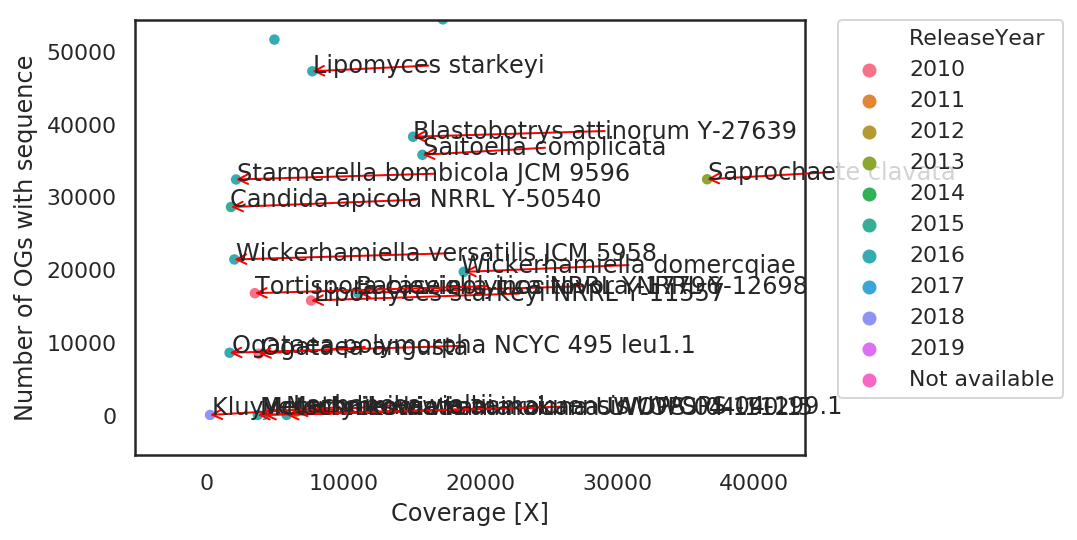

In [146]:

with sns.axes_style('white'):
    ax = sns.scatterplot(x='MBases', y='aa_len', hue='ReleaseYear', data=df2.sort_values(['ReleaseYear']))
#     ax.axhline(y=0.344862, xmin=0.0, xmax=1.0, color='r')
#     ax.axhline(y=0.586384, xmin=0.0, xmax=1.0, color='r')

#     ax.set(xlim=[0.1, 1000])
    ax.set_xlabel('Coverage [X]')
    ax.set_ylabel('Number of OGs with sequence')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    repel_labels(ax, xs, ys, labels, k=0.025)
#     ax.set(xscale="log")
#     ax.set(yscale="log")


    
# add regression line
#plt.savefig(os.path.join(TREE_DIR, 'out_mean_cov_dist_vs_num_ogs_Platform.pdf'), bbox_inches='tight', pad_inches=0)

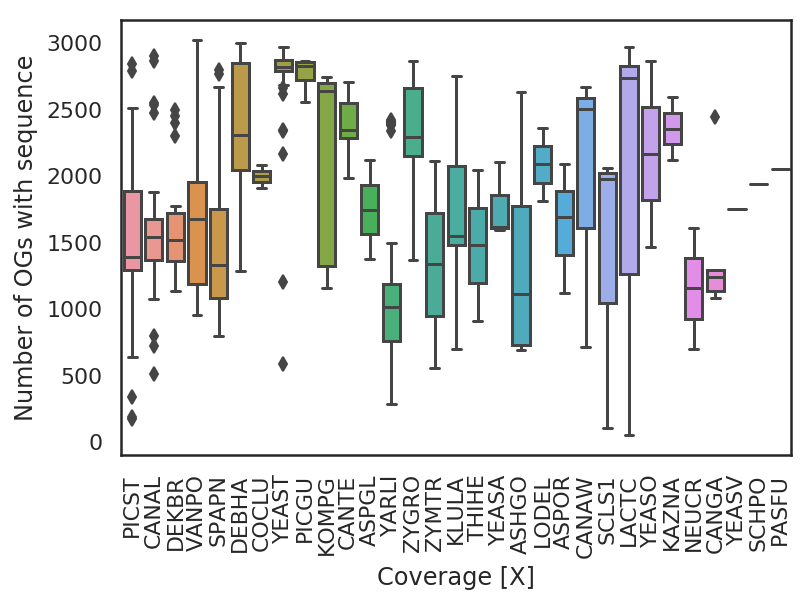

In [109]:
with sns.axes_style('white'):
    ax = sns.boxplot(x='max_used_sp', y='num_ogs', data=df2.sort_values(['Platform']))
    ax.set_xlabel('Coverage [X]')
    ax.set_ylabel('Number of OGs with sequence')
    plt.xticks(rotation=90)
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [65]:
for i, r in df2.iterrows():
    if r.r2tid is not np.NAN:
#     if r.scaled_ratio < 0.1:
#         print(str(r.species))
#     if 'Starmerella' in r.species:
#         print(str(r.species))
#         ax.text(r.coverage+.02, r.gc, str(r.species))
#     if int(r.num_ogs) < 800 and r.coverage > 5:
#         print(str(r.species))
#         ax.text(r.gc+.02, r.num_ogs, str(r.species))
        if r.gc<0.33 and r.gc >= 0.0:
            print(str(r.species), r.gc, r.coverage)
#             ax.text(r.coverage+.02, r.gc, str(r.use))

Ambrosiozyma oregonensis 0.3243769558823726 0.9707142857142858
Ascoidea asiatica 0.27709366710811567 0.6664285714285715
Candida arabinofermentans 0.3251062806178385 4.553571428571429
Candida boidinii 0.3147073413347073 0.7407142857142858
Hanseniaspora singularis 0.3254112155518063 0.23714285714285716
Kluyveromyces lactis 0.0 nan
Martiniozyma abiesophila 0.31787014187499485 0.10357142857142858
Metschnikowia hamakuensis 0.0 nan
Metschnikowia kamakouana 0.0 nan
Metschnikowia mauinuiana 0.0 nan
Ogataea ramenticola 0.3283755959215527 1.2560714285714285
Pachysolen tannophilus 0.3258622622473002 1.5764285714285715
Pichia exigua 0.3290004210014773 0.16285714285714287
Pichia heedii 0.3167766779190287 0.10285714285714286
Saccharomyces eubayanus 0.0 nan
Spathaspora arborariae 0.3195503382838579 7.363214285714286
Wickerhamomyces ciferrii 0.3195232648911642 nan
Yueomyces sinensis 0.32025711552690045 0.35714285714285715


In [148]:
df2.to_csv('/Users/daviddylus/Desktop/test7.csv', index=False)

In [34]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_select['ref_dist'], df_select['num_ogs'])
print(slope, intercept, r_value, p_value, std_err)

NameError: name 'df_select' is not defined

In [4]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df2)
# g.set(yscale="log")
# g.set(xscale="log")
plt.savefig(os.path.join('/Users/daviddylus/Desktop/', 'all_pair.pdf'), bbox_inches='tight', pad_inches=0)

/Users/daviddylus/miniconda3/envs/r2t/lib/python3.5/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/daviddylus/miniconda3/envs/r2t/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


In [25]:
for i,r in df2.iterrows():
    if r.r2tid is not np.NAN:
        if r.gc == 0.0 and r.ref is np.NAN:
            print(r.r2tid)

KLULA_1
METHA_1
METKA_1
METMA_1
SACEU_1


In [ ]:
with sns.axes_style('white'):
    sns.jointplot("out_mean_cov", "ratio", data=df_select, kind='hex')

## Get monophyly scores for families

In [ ]:
from ete3 import Tree,NCBITaxa
ncbi = NCBITaxa()
import numpy as np
t = Tree(tree_file)
new_to_old_name = {}
tree_species = []
order_to_species = {}
num_leaves = 0

for leaf in t:
    old_name = leaf.name
    if '-' in old_name:
        new_name = old_name.replace('-','X')
        leaf.name = new_name
    new_name = translate_name_dic[leaf.name]
    leaf.name = new_name
    tree_species.append(new_name)
t.set_outgroup( t&"Schizosaccharomyces pombe" )
t.ladderize()

name2taxid = ncbi.get_name_translator(tree_species)

# IMPORTANT: update of the database doesn't have to be done constantly
#ncbi.update_taxonomy_database()
species_to_order = {}
for k,v in name2taxid.items():
    lineage = ncbi.get_lineage(v[0])
    rank = ncbi.get_rank(lineage)
    for i,d in rank.items():
        if 'genus' == d:
            species_to_order[k] = i
    if k not in species_to_order.keys():
        species_to_order[k] = 1

for k,v in species_to_order.items():
    if v in order_to_species.keys():
        order_to_species[v].append(k)
    else:
        order_to_species[v] = [k]
def find_monophyletic(x,t):
    for node in t.traverse():
        leaves_at_node = set(node.get_leaf_names())
        if len(leaves_at_node - x) == 0 and len(leaves_at_node) > 1:
            return len(leaves_at_node & x)
        
species_part_of_low_monophyly = []
species_part_of_high_monophyly = []
all_mono = []
for k,v in order_to_species.items():
    if len(v) > 1:
        x = find_monophyletic(set(v),t)
        if x:
            mono = x/len(v)
            print('family {} has mono {}'.format(ncbi.get_taxid_translator([k])[k],mono))
            if mono < 0.5:
                species_part_of_low_monophyly += v
            else:
                species_part_of_high_monophyly += v
#                 print(v)
#                 print(ncbi.get_taxid_translator([k]))

print(len(species_part_of_low_monophyly))
print(len(species_part_of_high_monophyly))

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.scatter(cov, rat, c="g", alpha=0.5)

fuckers = 0
for i, k in enumerate(txt):
    r_date = int(release[k].split("/")[0])
#     if translate_name_dic[t] in species_part_of_high_monophyly:
#         ax.annotate(t, (cov[i], rat[i]))
#     ax.annotate(t, (cov[i], rat[i]))
    if rat[i] > 0.7:
        fuckers += 1
    if cov[i] > 5 and rat[i] < 0.5:
        print(k)
#         ax.annotate(library[k], (cov[i], rat[i]))
#         ax.annotate(k, (cov[i], rat[i]))
#         ax.annotate(library[k], (cov[i], rat[i]))
#     if 'ZOS' in t:
#         ax.annotate(t, (cov[i], rat[i]))
    if 'RNA' in strategy[k]:
        ax.annotate(k, (cov[i], rat[i]))
    if r_date > 2016:
        ax.scatter(cov[i], rat[i], c='b', alpha=0.5)
#     if 'Rest' in library[k]:
#         ax.scatter(cov[i], rat[i], c='b', alpha=0.5)
#         ax.annotate(library[k], (cov[i], rat[i]))
#     if 'GENOM' in source[k]:
#         ax.scatter(cov[i], rat[i], c='r', alpha=0.5)
        
print(fuckers)
# ax.hlines(y=0.7, xmin=0, xmax=28, linewidth=2, color='r')
# ax.annotate('{} species'.format(fuckers), (23, 0.75))
plt.xlabel("Coverage")
plt.ylabel("Non-X, Non-? to lenght of alginment")
plt.show()
#plt.savefig("/Users/daviddylus/Research/avian/concat_alignments/concat_350.scatter.pdf")


In [ ]:
r_cov_real = {}
r_cov = {}
num_ogs = {}
for file in tqdm.tqdm(glob.glob("/Users/daviddylus/mnt/weekly/avian/r2t_400/*cov.txt")):
    name = os.path.basename(file).split("_")[0]
    sc = pd.read_csv(file)
    row_sum = sc.sum()['coverage']
    r_cov[name] = np.mean(sc['coverage'])
    num_ogs[name] = len(sc['coverage'])
    r_cov_real[name] = row_sum/9744

In [ ]:
sc_mean = {}
sc_num = {}
sc_scaled_average = {}
for file in tqdm.tqdm(glob.glob("/Users/daviddylus/mnt/weekly/avian/r2t_400/*sc.txt")):
    name = os.path.basename(file).split("_")[0]
    sc_table = pd.read_csv(file)
    row_sum = sc_table.sum()['map_seq_completeness']
    sc_mean[name] = np.mean(sc_table['map_seq_completeness'])
    sc_num[name] = len(sc['coverage'])
    sc_scaled_average[name] = row_sum/9744

In [ ]:
r_cov

In [ ]:
r_cov2 = np.array([r_cov_real[k] for k,v in ratio.items() if k in r_cov.keys() and k in cov_dic.keys()])
cov2 = np.array([cov_dic[k] for k,v in ratio.items() if k in cov_dic.keys() and k in r_cov.keys()])
num_ogs2 = np.array([num_ogs[k] for k,v in ratio.items() if k in cov_dic.keys() and k in r_cov.keys()])
sc2 = np.array([sc_scaled_average[k] for k,v in ratio.items() if k in cov_dic.keys() and k in r_cov.keys()])
sc2

In [ ]:
Y coverage of OGS
X use total coverage
log scale x

fig, ax = plt.subplots()
ax.scatter(r_cov2, sc2, c="g", alpha=0.5)
# ax.set_yscale('log')
# ax.xcorr(r_cov2, cov2)
# fuckers = 0
for i, k in enumerate(txt):
    if 'Rest' in library[k]:
        ax.scatter(r_cov2[i], sc2[i], c='b', alpha=0.5)
#     if rat[i] > 0.5:
#         fuckers += 1
#     if cov[i] > 20:
#         print(translate_name_dic[t])
#         ax.annotate(t, (cov[i], rat[i]))
# print(fuckers)
# ax.hlines(y=0.5, xmin=0, xmax=28, linewidth=2, color='r')
# ax.annotate('{} species'.format(fuckers), (23, 0.75))
plt.xlabel("Given Coverage")
plt.ylabel("Obtained Coverage")
# plt.show()
plt.savefig("/Users/daviddylus/Research/avian/concat_alignments/covearge.pdf")
